In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras as keras
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Activation, Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape, Concatenate, concatenate

### 数据处理

In [2]:

data_ini = pd.read_excel('data/BJ POLTS.xlsx')

data = data_ini.iloc[:,[1,3,4,5,6,7,8]]
data.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,142,109,138,88,61,2.6,11
1,86,64,86,54,38,1.6,45
2,109,82,101,62,42,2.0,23
3,56,39,56,38,30,1.2,52
4,169,128,162,78,48,2.5,15


In [3]:

def expPreprocessing(df, alpha=0.05):
    edata = df.ewm(alpha=alpha, adjust=False).mean()
    return edata

alpha = 0.05
data_exp = expPreprocessing(data, alpha)
data_exp.head()

# alpha = 0.05
# data_exp = data.ewm(alpha=alpha, adjust=False).mean()
# data_exp.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,142.000000,109.000000,138.0000,88.000000,61.000000,2.600000,11.000000
1,139.200000,106.750000,135.4000,86.300000,59.850000,2.550000,12.700000
2,137.690000,105.512500,133.6800,85.085000,58.957500,2.522500,13.215000
3,133.605500,102.186875,129.7960,82.730750,57.509625,2.456375,15.154250
4,135.375225,103.477531,131.4062,82.494213,57.034144,2.458556,15.146538


In [4]:

min_value = data_exp.min(axis=0)  
max_value = data_exp.max(axis=0)

data_std = (data_exp - min_value) / (max_value - min_value)

In [5]:


time_stamp = 50  
ratio = 0.8

split = int(ratio*len(data))
train_data = data_std[0:split + time_stamp]
valid_data = data_std[split - time_stamp:]

In [6]:
label_column = 0 
x_train, y_train = [], []
scaled_data = train_data.values

for i in range(time_stamp, len(train_data)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, label_column])

x_train, y_train = np.array(x_train), np.array(y_train)



x_valid, y_valid = [], []
scaled_data = valid_data.values
for i in range(time_stamp, len(valid_data)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, label_column])
    
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

### 网络定义

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_model(x, hidden_1, hidden_2, dropout_rate=0.1, attention_dim=11, num_heads=4):
    x_input = Input(shape=(x.shape[1], x.shape[2]))
    # x_input1 = layers.Conv1D(filters=34, kernel_size=1, padding='same', activation='relu')(x_input)
    # x_input1 = layers.MaxPool1D(pool_size=7, padding='valid')(x_input1)
    
    AQI, P = x_input[:,:,0], x_input[:,:,1:]
    feature_time_lag = mlp(AQI, [hidden_1, hidden_2], dropout_rate)
    feature_pol_con = mlp(P, [hidden_1, hidden_2], dropout_rate)
    feature_seasonal = mlp(x_input, [hidden_1, hidden_2], dropout_rate)
    
    x_input1= layers.Dense(hidden_2)(x_input)
    '''
    
    x_features = layers.Add()([x_input1, feature_time_lag, feature_pol_con, feature_seasonal])
    
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=attention_dim, dropout=0.0799
    )(x_input1, x_features)
    # Skip connection 1.
    x2 = layers.Add()([attention_output, x_input1])
    '''
    '''
   
    x_features = layers.Add()([x_input1, feature_time_lag, feature_pol_con, feature_seasonal])
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=attention_dim, dropout=0.0799
    )(x_features, x_features)
    # Skip connection 1.
    x2 = layers.Add()([attention_output, x_features])
    '''
   
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=attention_dim, dropout=0.0799
    )(x_input1, x_input1)
    # Skip connection 1.
    x2 = layers.Add()([attention_output, feature_time_lag, feature_pol_con, feature_seasonal])
    
    
    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, hidden_units=[hidden_2], dropout_rate=dropout_rate)

    # Skip connection 2.
    encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, attention_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout_rate)(representation)
    # Classify outputs.
    logits = layers.Dense(1)(representation)
    logits = layers.Dropout(dropout_rate)(logits)
    # Create the Keras model.
    return Model(inputs=x_input, outputs=logits)

### 贝叶斯参数优化

In [8]:
import optuna

class Trainer():
    def __init__(self, 
                 x_train, 
                 y_train, 
                 x_valid, 
                 y_valid,  
                 num_heads=4,
                 epochs=50, 
                 batch_size=64,
                 n_trials=100
                ):
        self.x_train, self.y_train, self.x_valid, self.y_valid = x_train, y_train, x_valid, y_valid
        self.num_heads = num_heads
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_trials = n_trials
        

    def objective(self, trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        hidden_1 = trial.suggest_int('hidden_1', 32, 256)
        hidden_2 = trial.suggest_int('hidden_2', 32, 256)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0., 0.01)
        attention_dim = trial.suggest_int('attention_dim', 8, 128)
        
        model = transformer_model(x=self.x_train, 
                                  hidden_1=hidden_1, 
                                  hidden_2=hidden_2, 
                                  dropout_rate=dropout_rate, 
                                  attention_dim=attention_dim, 
                                  num_heads=self.num_heads
                                 )
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        #score = model.evaluate(x_valid, y_valid, verbose=0)
        y_pred = model.predict(self.x_valid)
        score = mean_squared_error(self.y_valid, y_pred)

        return score
    
    def optimizer_optuna(self):
        algo = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=algo, direction='minimize')
        study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)
        return study

D:\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
# 超参数
epochs = 5
batch_size = 64
num_heads = 4
n_trials = 10

T = Trainer(x_train, y_train, x_valid, y_valid, num_heads=num_heads, epochs=epochs, batch_size=batch_size, n_trials=n_trials)
study = T.optimizer_optuna()
print(study.best_params)
print(study.best_value)

[I 2024-01-29 14:37:52,548] A new study created in memory with name: no-name-14314398-6fc0-453b-ac0e-d1506b64e0f3
D:\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2024-01-29 14:38:04,659] Trial 0 finished with value: 0.006794752185020685 and parameters: {'lr': 0.006787854603676972, 'hidden_1': 113, 'hidden_2': 82, 'dropout_rate': 0.009862788031623344, 'attention_dim': 76}. Best is trial 0 with value: 0.006794752185020685.
[I 2024-01-29 14:38:15,921] Trial 1 finished with value: 0.030700546391489385 and parameters: {'lr': 1.3462755207546296e-05, 'hidden_1': 226, 'hidden_2': 141, 'dropout_rate': 0.008797840803126351, 'attention_dim': 13}. Best is trial 0 with value: 0.006794752185020685.
[I 2024-01-29 14:38:32,659] Trial 2 finished with value: 0.015108642309503208 and parameters: {'lr': 0.000223058160892181, 'hidden_1': 60, 'hidden_2': 250, 'dropout_rate': 0.0012932118279706474, 'attention_dim': 58}. Best is trial 0 with value: 0.006794752185020685.
[I 2024-01-29 14:38:46,782] Trial 3 finished with value: 0.05114702653570145 and parameters: {'lr': 1.0467239717311305e-05, 'hidden_1': 209, 'hidden_2': 142, 'dropout_rate': 0.002526604278163228, 'a

In [10]:
# 根据最优超参，训练和预测
params = study.best_params
lr = params['lr']
hidden_1 = params['hidden_1']
hidden_2 = params['hidden_2']
dropout_rate = params['dropout_rate']
attention_dim = params['attention_dim']

checkpoint_path_best = "data/best.hdf5"
modelcheckpoint_best = keras.callbacks.ModelCheckpoint(checkpoint_path_best,
                                                       monitor='loss',
                                                       save_best_only=True, 
                                                       mode='min', 
                                                       verbose=0)
model = transformer_model(x=x_train, 
                          hidden_1=hidden_1, 
                          hidden_2=hidden_2, 
                          dropout_rate=dropout_rate, 
                          attention_dim=attention_dim
                         )
#print(model.summary())
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
model.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=1, callbacks=[modelcheckpoint_best])

model.load_weights(checkpoint_path_best)
closing_price = model.predict(x_valid)

Epoch 1/100
41/41 [==============================] - 3s 54ms/step - loss: 6.7154
Epoch 2/100
 3/41 [=>............................] - ETA: 2s - loss: 0.1577

D:\anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


41/41 [==============================] - 2s 53ms/step - loss: 0.0636
Epoch 3/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0386
Epoch 4/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0387
Epoch 5/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0371
Epoch 6/100
41/41 [==============================] - 2s 55ms/step - loss: 0.0298
Epoch 7/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0306
Epoch 8/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0294
Epoch 9/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0312
Epoch 10/100
41/41 [==============================] - 2s 54ms/step - loss: 0.0276
Epoch 11/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0423
Epoch 12/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0601
Epoch 13/100
41/41 [==============================] - 2s 53ms/step - loss: 0.0294
Epoch 14/100
41/41 [================

In [11]:
# closing_price = scaler.inverse_transform(closing_price)
# y_valid = scaler.inverse_transform([y_valid])
y_valid_list = [y_valid]

mse_2 = mean_squared_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("RMSE ", np.sqrt(mse_2))
mae = mean_absolute_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAE ", mae)
r2 = r2_score(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("R2SCORE ", r2)
mape = mean_absolute_percentage_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAPE ", mape)

RMSE  0.03343969046650591
MAE  0.0289744341637187
R2SCORE  0.9036753452758155
MAPE  426378809707.6279


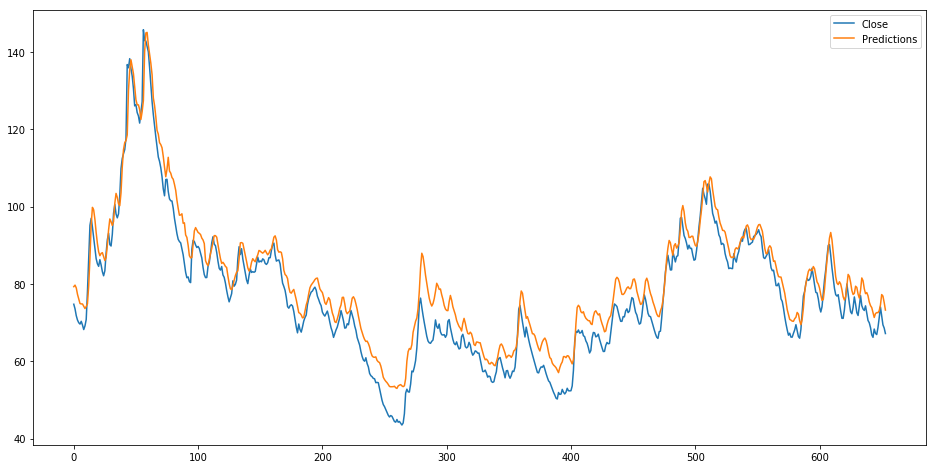

In [12]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 反归一化
closing_price_original = (closing_price.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
y_valid_original = (y_valid.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
# 创建图表
plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price_original.flatten(),
    'Close': y_valid_original.flatten()
}
data_pd = pd.DataFrame(dict_data)
plt.plot(data_pd[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()
# 保存预测值
pd.DataFrame(closing_price_original).to_csv('data/ADNNet_pred_BJ.csv', index=False)
pd.DataFrame(y_valid_original).to_csv('data/Real_BJ.csv', index=False)

In [13]:
# valid.iloc[time_stamp:,0].values == y_valid

train_labels = list(data.iloc[:split,0])   # data.iloc[split:,0]
test_labels = list(data.iloc[:,0])

prediction_values = closing_price.reshape(1,-1)[0]
prediction_exp = prediction_values * (max_value[0] - min_value[0]) + min_value[0]
prediction_list = list(prediction_exp)
all_labels = train_labels + prediction_list

labels_dict = {'prediction': all_labels, 'test': test_labels}
df_labels = pd.DataFrame(labels_dict)

In [14]:
df_labels

,prediction,test
0,142.000000,142
1,86.000000,86
2,109.000000,109
3,56.000000,56
4,169.000000,169
5,291.000000,291
6,223.000000,223
7,26.000000,26
8,45.000000,45
9,30.000000,30


In [15]:
def exp_reversed(df, alpha):
    row_0 = df.iloc[0]
    df_t_1 = df.iloc[:0].append(row_0, ignore_index=True).append(df.iloc[:-1], ignore_index=True)
    results = (df - (1-alpha)*df_t_1)/alpha
    results.iloc[0] = df.iloc[0]
    return results
    
original_labels = exp_reversed(df_labels, alpha)
original_labels

,prediction,test
0,142.000000,142.0
1,-978.000000,-978.0
2,546.000000,546.0
3,-951.000000,-951.0
4,2316.000000,2316.0
5,2609.000000,2609.0
6,-1069.000000,-1069.0
7,-3717.000000,-3717.0
8,406.000000,406.0
9,-255.000000,-255.0
